# Exploratory Stuff

In [1]:
# init

import datetime

from matplotlib import pyplot
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import seaborn as sns

from covid19stats.common import get_db_conn

conn = get_db_conn()

sns.set(style="darkgrid")

a4_dims = (11.7, 8.27)

N=5708


,confirmed,deaths
confirmed,1.000000,0.935537
deaths,0.935537,1.000000


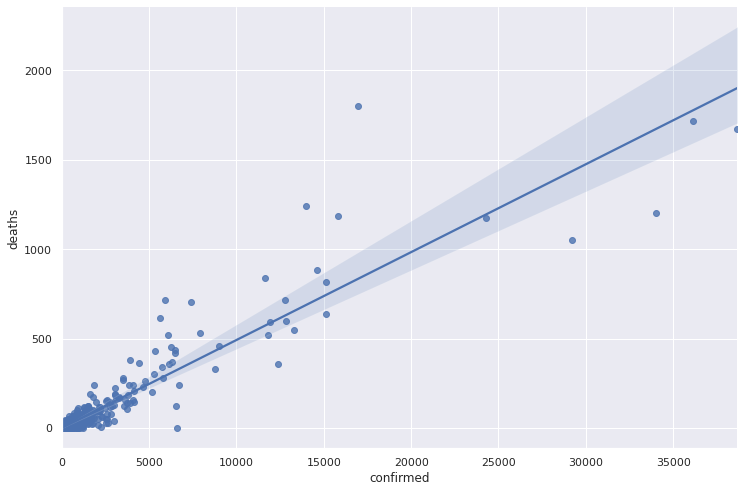

In [2]:
# sanity check: is this thing on?
# of course confirmed cases will be highly correlated with deaths, duh

sql = """
SELECT
    Confirmed,
    Deaths
FROM fact_counties_base
WHERE
    Date = '2020-05-01'
    -- exclude NYC outlier 
    AND FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="confirmed", y="deaths", data=df, height=7, aspect=1.5)

df.corr()

Is there a correlation between new cases and deaths?

Look at correlation for values on same day, and for a two-week lag for deaths.

Note that the drop on 6-11 is due to Michigan counties suddenly reporting additional deaths.
This is logged in the notes in the CSSE repo. It throws off the correlation.

In [3]:
def get_corr(df, date, col1, col2):
    new_df = df[df['date']==date].drop(columns=['date'])
    return new_df[col1].corr(new_df[col2])

def corr_over_time(df, col1, col2):
    pairs = [[date, get_corr(df, date, col1, col2)] for date in df['date'].unique()]

    results = pd.DataFrame(pairs, columns = ['date', 'corr'])  
    results = results.sort_values(['date'])

    results['date']= pd.to_datetime(results['date']) 

    return results

## new cases and deaths on same day

sql = """
SELECT
    Date,
    Avg7DayConfirmedIncrease,
    Avg7DayDeathsIncrease
FROM fact_counties_base
"""

df = psql.read_sql(sql, conn)

results = corr_over_time(df, 'avg7dayconfirmedincrease', 'avg7daydeathsincrease')

## new cases and 2 week time lag for deaths 

sql = """
SELECT
    earlier.Date,
    earlier.Avg7DayConfirmedIncrease,
    later.Avg7DayDeathsIncrease
FROM fact_counties_base earlier
JOIN fact_counties_base later
    ON earlier.FIPS = later.FIPS
    AND earlier.Date = later.Date - interval '-14 days'
"""

df_lag = psql.read_sql(sql, conn)

results_lag = corr_over_time(df_lag, 'avg7dayconfirmedincrease', 'avg7daydeathsincrease')

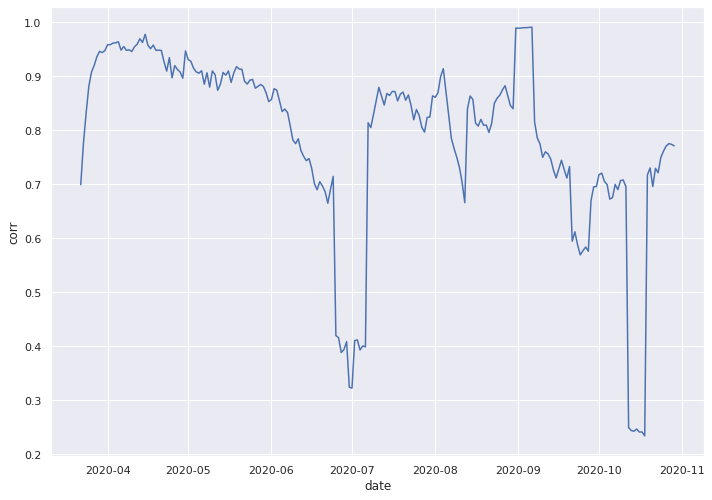

In [4]:
# Correlation for same day values

fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(x="date", y="corr", data=results, ax=ax);

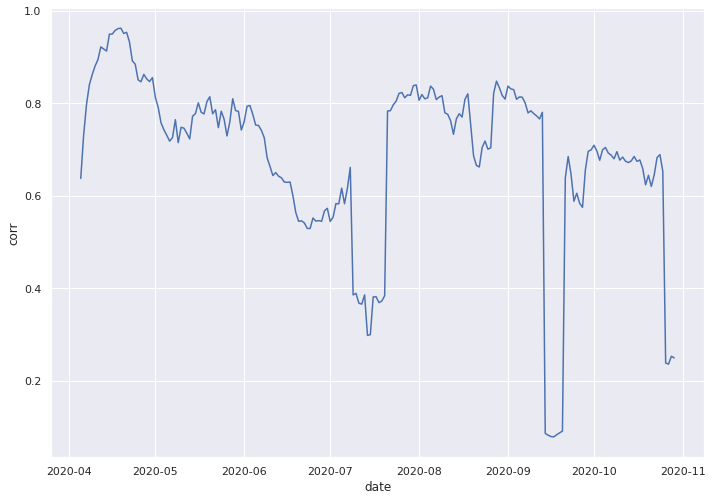

In [5]:
# Correlection, when account for Two Week Lag in Deaths

fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(x="date", y="corr", data=results_lag, ax=ax);

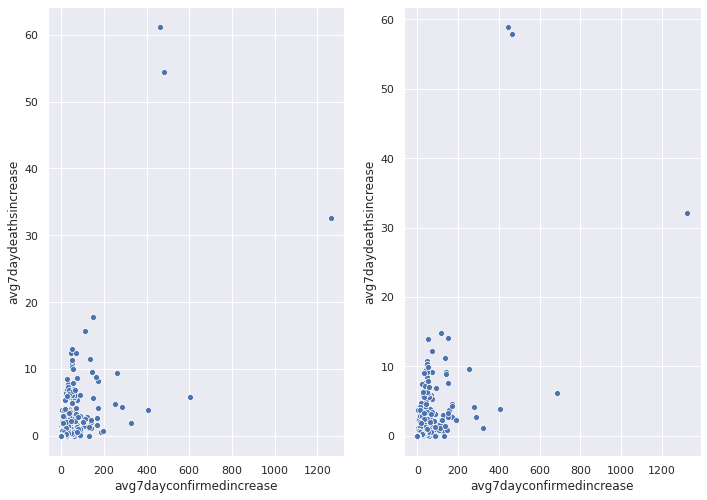

In [6]:
# notice what happens on 6-11: deaths skyrocket for a few counties. This is the Michigan issue.

fig, ax = pyplot.subplots(1, 2, figsize=a4_dims)

sns.scatterplot(x='avg7dayconfirmedincrease', y='avg7daydeathsincrease', \
                data=df_lag[df_lag['date']==datetime.date(year=2020,month=6,day=10)], ax=ax[0]);

sns.scatterplot(x='avg7dayconfirmedincrease', y='avg7daydeathsincrease', \
                data=df_lag[df_lag['date']==datetime.date(year=2020,month=6,day=11)], ax=ax[1]);

N=5700


,confirmed,population
confirmed,1.00000,0.60398
population,0.60398,1.00000


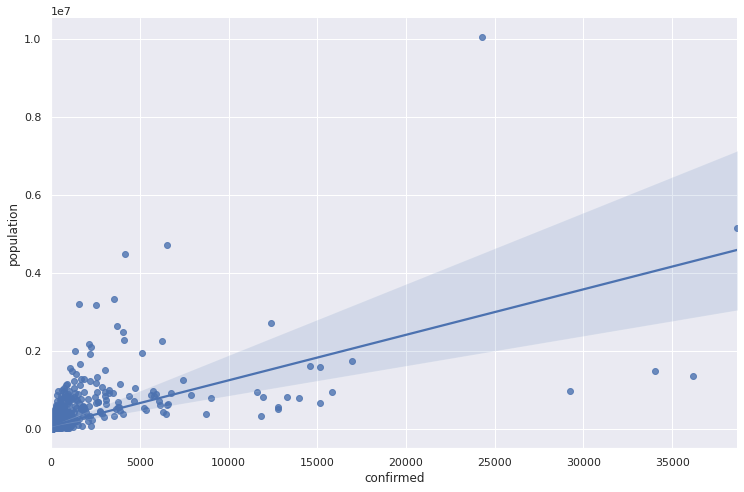

In [7]:
# is there a correlation with population size?
# we'd expect so, since outbreaks began in large cities.
# correlation probably decreases over time

sql = """
SELECT
    Confirmed,
    Population
FROM fact_counties_base b
JOIN dim_county c
    ON b.FIPS = c.FIPS
WHERE
    Date = '2020-05-01'
    AND Population > 0
    AND Confirmed >= 0
    -- exclude NYC outlier 
    AND b.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="confirmed", y="population", data=df, height=7, aspect=1.5)

df.corr()

N=5390


,deaths,medianage
deaths,1.000000,-0.067186
medianage,-0.067186,1.000000


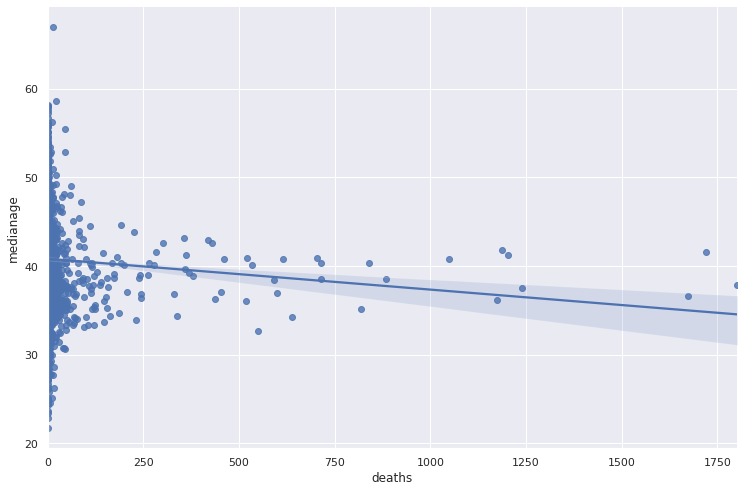

In [8]:
# no correlation with median age, which is odd

sql = """
SELECT
    Deaths,
    MedianAge
FROM fact_counties_base cr
JOIN dim_county c
    ON cr.FIPS = c.FIPS
WHERE
    Date = '2020-05-01'
    AND MedianAge > 0
    AND Deaths >= 0
    -- exclude NYC outlier 
    AND cr.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="deaths", y="medianage", data=df, height=7, aspect=1.5)

df.corr()

,deaths,medianage
deaths,1.000000,-0.205324
medianage,-0.205324,1.000000


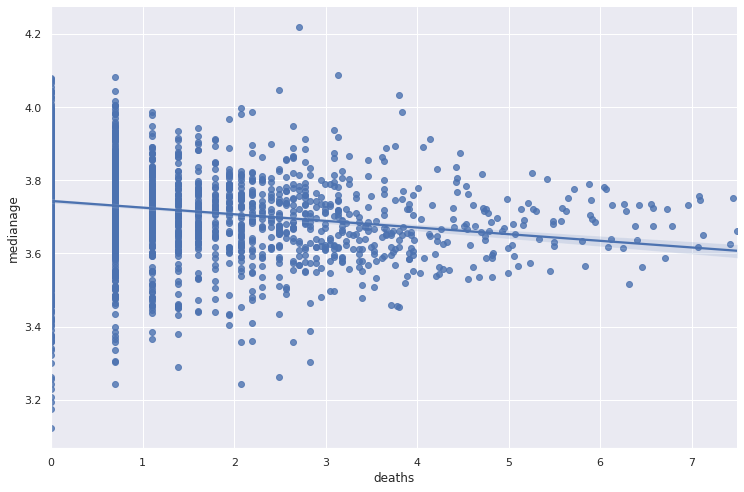

In [9]:
# try log transform to spread out the data

sns.lmplot(x="deaths", y="medianage", data=np.log1p(df), height=7, aspect=1.5)

np.log1p(df).corr()

N=5388


,confirmed,medianincome
confirmed,1.000000,0.248781
medianincome,0.248781,1.000000


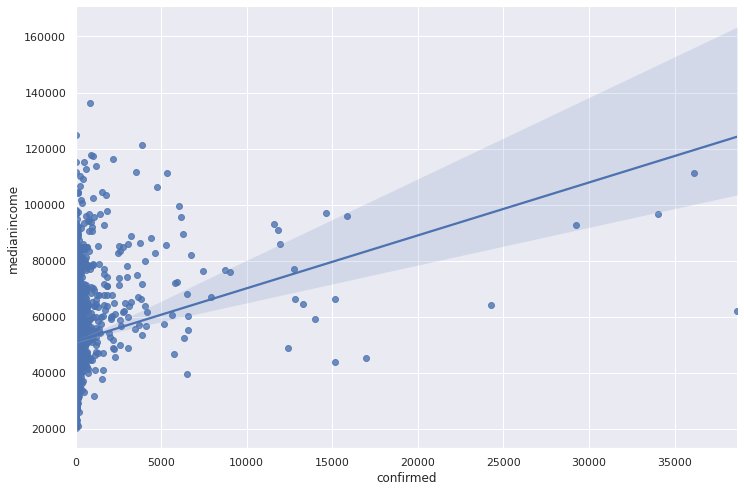

In [10]:
# very slight correlation with median income?

sql = """
SELECT
    Confirmed,
    MedianIncome
FROM fact_counties_base b
JOIN dim_county c
    ON b.FIPS = c.FIPS
WHERE
    Date = '2020-05-01'
    AND MedianIncome > 0
    AND Confirmed >= 0
    -- exclude NYC outlier 
    AND b.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="confirmed", y="medianincome", data=df, height=7, aspect=1.5)

df.corr()

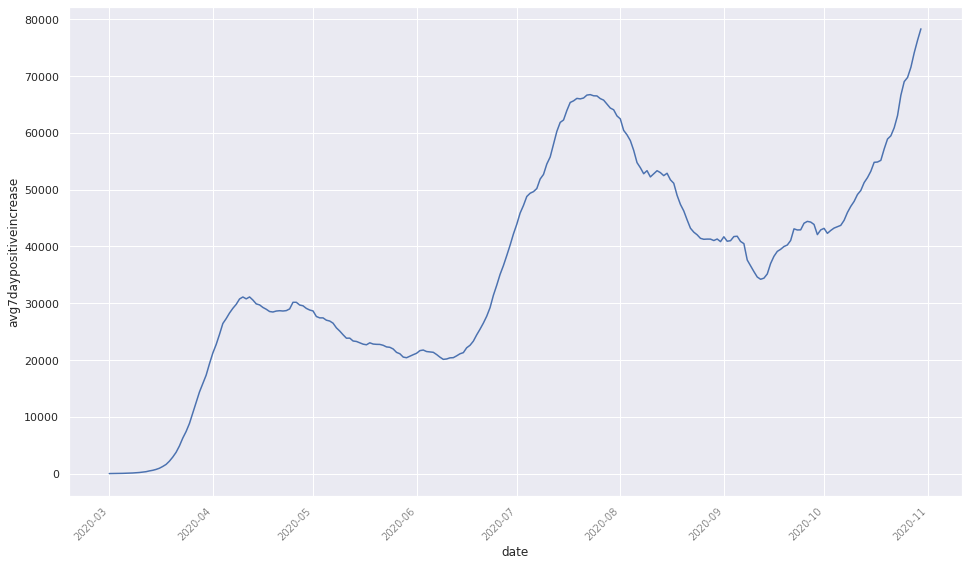

In [11]:
# plot for national trend in new cases

sql = """
    select 
        Date, Avg7DayPositiveIncrease
    from fact_nation n
    where date >= '2020-03-01'
    order by Date;
"""

df = psql.read_sql(sql, conn)

fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

chart = sns.lineplot(x="date", y="avg7daypositiveincrease", data=df, ax=ax)

pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
);

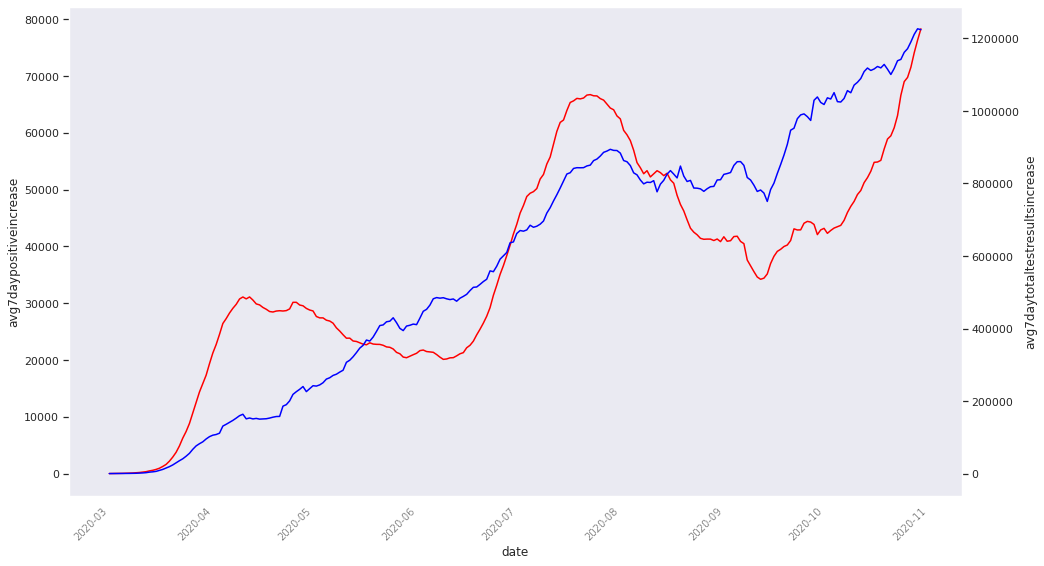

In [12]:
# compare total test results with new cases.
# testing had been steadily increasing but began to drop around Aug 1st.
# this means the drop in the new cases may be due to less testing.

sql = """
    select 
        Date, Avg7DayPositiveIncrease, Avg7DayTotalTestResultsIncrease
    from fact_nation n
    where date >= '2020-03-01'
    order by Date;
"""

df = psql.read_sql(sql, conn)

sns.set(style="dark")

fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

chart = sns.lineplot(x="date", y="avg7daypositiveincrease", data=df, ax=ax, color='red')

# for index, label in enumerate(ax.xaxis.get_ticklabels()):
#     if index % 7 != 0:
#         label.set_visible(False)

pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
);

ax2 = ax.twinx()

chart = sns.lineplot(x="date", y="avg7daytotaltestresultsincrease", data=df, ax=ax2, color='blue')

# needed to avoid scientific notation on this y-axis
pyplot.ticklabel_format(style='plain', axis='y')

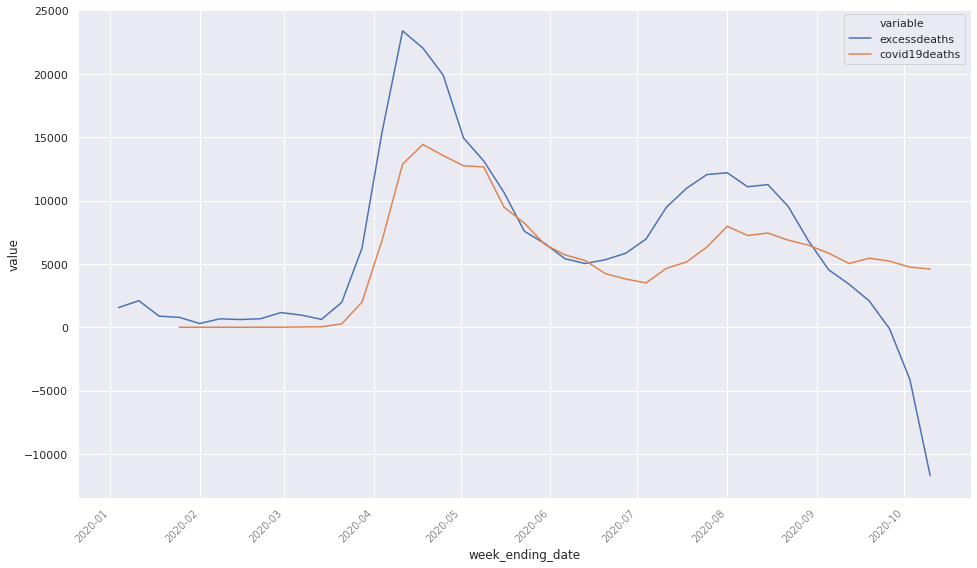

In [13]:
# compare reported covid-19 deaths with excess deaths

sql = """
    select 
        Week_Ending_Date, SUM(Excess) as ExcessDeaths, SUM(Covid19DeathsForWeek) as Covid19Deaths
    from fact_state_deaths
    group by Week_Ending_Date
    order by Week_Ending_Date;
"""

df = psql.read_sql(sql, conn)

df = pd.melt(df, id_vars=['week_ending_date'])

sns.set(style="darkgrid")

fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

chart = sns.lineplot(x="week_ending_date", y="value", hue="variable", data=df, ax=ax)

pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
);